In [1]:
scene_path = "../data/train/cloud/BH_RAF08MAY2024038491010700053SSANSTUC00GTDA"

In [2]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from glob import glob
print("yes")


yes


In [3]:
# === Metadata Constants ===
sun_elevation = 69.011613
sun_zenith_angle = 90 - sun_elevation
theta_rad = np.deg2rad(sun_zenith_angle)
d = 0.983  # Earth–Sun distance (AU)

# Lmin, Lmax for RS-2A LISS-4 (Green, Red, NIR)
Lmin = [0.0, 0.0, 0.0]
Lmax = [52.0, 47.0, 31.5]

# Esun values for RS-2A (Green, Red, NIR)
Esun = [185.347, 158.262, 110.81]
print("yes")

yes


In [4]:
def dn_to_radiance(dn_band, lmin, lmax):
    return lmin + (dn_band / 255.0) * (lmax - lmin)

def radiance_to_reflectance(L, esun, d, theta_rad):
    return (np.pi * L * d**2) / (esun * np.cos(theta_rad))


In [5]:
# Make sure paths are correct based on where your notebook is
input_folder = "CLOUD/data/train/cloudimages"
output_folder = "CLOUD/data/train/reflectance"


# Get all .tif images
image_paths = glob(os.path.join(input_folder, "*.tif"))
print("Found", len(image_paths), "images")

# Print image names to verify
for img in image_paths:
    print(" -", img)


Found 0 images


In [6]:
from PIL import Image
import os
from glob import glob

input_folder = "../data/train/cloudimages"
output_folder = "../data/train/cloudimages_tiff"
os.makedirs(output_folder, exist_ok=True)

# Convert all JPGs to TIFFs
jpg_paths = glob(os.path.join(input_folder, "*.jpg"))

for path in jpg_paths:
    img = Image.open(path).convert("RGB")  # Ensure 3-channel
    filename = os.path.basename(path).replace(".jpg", ".tif")
    output_path = os.path.join(output_folder, filename)
    img.save(output_path, format="TIFF")
    print(f"Saved: {output_path}")


In [8]:
import rasterio
import numpy as np
import os

def read_bands(scene_path):
    band_paths = {
        "BAND2": os.path.join(scene_path, "BAND2.tif"),
        "BAND3": os.path.join(scene_path, "BAND3.tif"),
        "BAND4": os.path.join(scene_path, "BAND4.tif")
    }

    bands = {}
    for band_name, path in band_paths.items():
        with rasterio.open(path) as src:
            bands[band_name] = src.read(1).astype(np.float32)
            meta = src.meta  # use BAND2's metadata for writing later

    return bands, meta



In [9]:
bands, meta = read_bands(scene_path)

print("✅ Bands loaded:")
for k in bands:
    print(f"{k}: shape = {bands[k].shape}, dtype = {bands[k].dtype}")

✅ Bands loaded:
BAND2: shape = (16735, 17891), dtype = float32
BAND3: shape = (16735, 17891), dtype = float32
BAND4: shape = (16735, 17891), dtype = float32


In [10]:
meta_path = "../data/train/cloud/BH_RAF08MAY2024038491010700053SSANSTUC00GTDA/BAND_META.txt"

In [11]:
def read_metadata(meta_path):
    sun_elevation = None
    Lmin = {}
    Lmax = {}

    with open(meta_path, "r") as f:
        for line in f:
            if "SunElevationAtCenter" in line:
                sun_elevation = float(line.split("=")[-1].strip())
            for band in ["B2", "B3", "B4"]:
                if f"{band}_Lmin" in line:
                    Lmin[band] = float(line.split("=")[-1].strip())
                elif f"{band}_Lmax" in line:
                    Lmax[band] = float(line.split("=")[-1].strip())
                    
    return sun_elevation, Lmin, Lmax

# Call it
meta_path = os.path.join(scene_path, "BAND_META.txt")
sun_elev, Lmin, Lmax = read_metadata(meta_path)

print("✅ Sun Elevation:", sun_elev)
print("✅ Lmin:", Lmin)
print("✅ Lmax:", Lmax)


✅ Sun Elevation: 70.708525
✅ Lmin: {'B2': 0.0, 'B3': 0.0, 'B4': 0.0}
✅ Lmax: {'B2': 52.0, 'B3': 47.0, 'B4': 31.5}


In [12]:
from math import pi, radians, cos

def dn_to_radiance(dn, lmin, lmax):
    return lmin + (dn / 255.0) * (lmax - lmin)

def radiance_to_reflectance(L, Esun, d, theta_rad):
    return (pi * L * d**2) / (Esun * cos(theta_rad))

def convert_to_reflectance(bands, sun_elevation, Lmin, Lmax):
    Esun = {
        "BAND2": 185.347,
        "BAND3": 158.262,
        "BAND4": 110.81
    }
    d = 1.0  # Earth-Sun distance (can be taken from CSV later)
    theta_rad = radians(90 - sun_elevation)

    reflectance = {}
    for band in bands:
        band_key = band.replace("BAND", "B")  # e.g., BAND2 → B2
        L = dn_to_radiance(bands[band], Lmin[band_key], Lmax[band_key])
        reflectance[band] = np.clip(
            radiance_to_reflectance(L, Esun[band], d, theta_rad),
            0, 1
        )

    return reflectance

# Call it
reflectance = convert_to_reflectance(bands, sun_elev, Lmin, Lmax)

print("✅ Reflectance computed.")
for k in reflectance:
    print(f"{k}: min={reflectance[k].min():.3f}, max={reflectance[k].max():.3f}")

✅ Reflectance computed.
BAND2: min=0.000, max=1.000
BAND3: min=0.000, max=1.000
BAND4: min=0.000, max=1.000


In [13]:
def classify_pixels_temp(reflectance):
    b2 = reflectance["BAND2"]
    b3 = reflectance["BAND3"]
    b4 = reflectance["BAND4"]

    mask = np.zeros_like(b2, dtype=np.uint8)

    # Optional: ignore zero-value pixels (probably nodata)
    valid = (b2 > 0) & (b3 > 0) & (b4 > 0)

    # 🌥️ CLOUD: very bright in all visible bands
    cloud = (b2 > 0.35) & (b3 > 0.23) & (b4 > 0.22)

    # 🌑 SHADOW: very dark in all bands + valid NDVI filtering
   
    ndvi = (b4 - b3) / (b4 + b3 + 1e-6)
    shadow = (
    (b2 < 0.1) & (b3 < 0.1) & (b4 < 0.12) & 
    (ndvi < 0.15)
    )



    mask[cloud] = 1
    mask[shadow] = 2

    return mask

In [14]:
mask = classify_pixels_temp(reflectance)

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def analyze_reflectance_by_class(reflectance, mask):
    classes = {
        0: "NOCLOUD",
        1: "CLOUD",
        2: "SHADOW"
    }

    bands = ["BAND2", "BAND3", "BAND4"]
    colors = {0: "gray", 1: "red", 2: "blue"}

    plt.figure(figsize=(18, 4))

    for i, band in enumerate(bands):
        band_data = reflectance[band].flatten()
        band_mask = mask.flatten()

        plt.subplot(1, 3, i + 1)
        for cls in [0, 1, 2]:
            class_vals = band_data[band_mask == cls]
            if len(class_vals) > 0:
                plt.hist(class_vals, bins=100, alpha=0.6,
                         label=f"{classes[cls]}", color=colors[cls])
        
        plt.title(f"{band} Reflectance Histogram")
        plt.xlabel("Reflectance")
        plt.ylabel("Pixel Count")
        plt.legend()

    plt.tight_layout()
    plt.show()

    print("📊 Class-wise Reflectance Statistics:")
    for cls in [0, 1, 2]:
        print(f"\n--- {classes[cls]} ---")
        for band in bands:
            vals = reflectance[band][mask == cls]
            if len(vals) == 0:
                print(f"{band}: [no pixels]")
            else:
                print(f"{band}: min={vals.min():.3f}, mean={vals.mean():.3f}, max={vals.max():.3f}")

In [16]:
unique, counts = np.unique(mask, return_counts=True)
print("Mask class counts:", dict(zip(unique, counts)))

Mask class counts: {np.uint8(0): np.int64(176), np.uint8(1): np.int64(236866731), np.uint8(2): np.int64(62538978)}


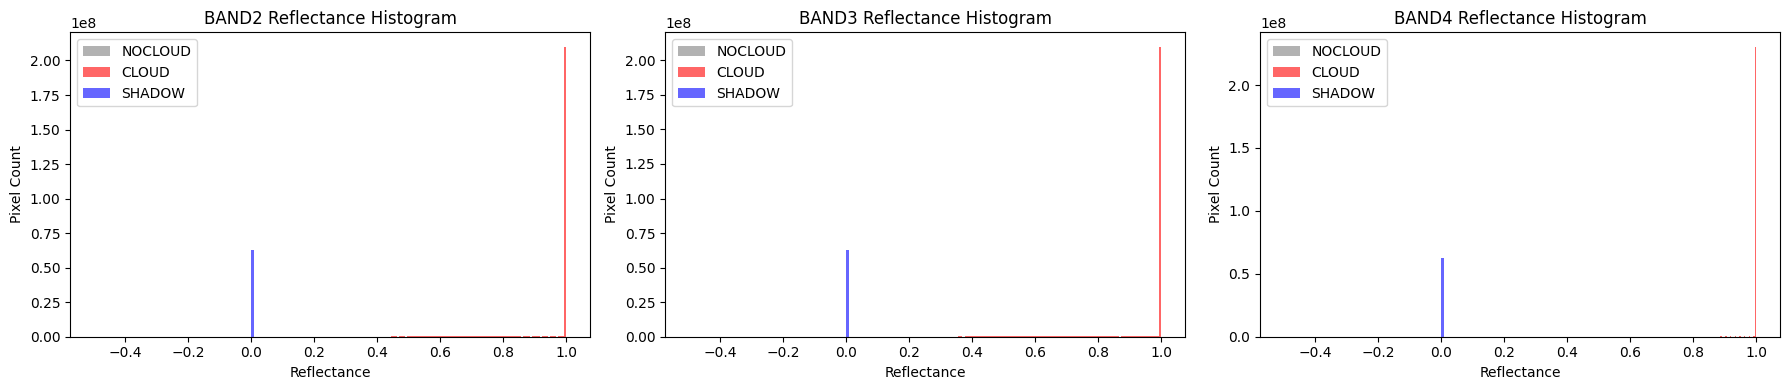

📊 Class-wise Reflectance Statistics:

--- NOCLOUD ---
BAND2: min=0.341, mean=0.347, max=0.348
BAND3: min=0.267, mean=0.397, max=0.585
BAND4: min=0.701, mean=0.871, max=1.000

--- CLOUD ---
BAND2: min=0.352, mean=0.966, max=1.000
BAND3: min=0.248, mean=0.961, max=1.000
BAND4: min=0.505, mean=0.997, max=1.000

--- SHADOW ---
BAND2: min=0.000, mean=0.000, max=0.000
BAND3: min=0.000, mean=0.000, max=0.000
BAND4: min=0.000, mean=0.000, max=0.000


In [17]:
analyze_reflectance_by_class(reflectance, mask)

In [18]:
mask = classify_pixels_temp(reflectance)

unique, counts = np.unique(mask, return_counts=True)
label_map = {0: "NOCLOUD", 1: "CLOUD", 2: "SHADOW"}
print("✅ Mask Class Distribution:")
for u, c in zip(unique, counts):
    print(f"{label_map[u]} ({u}): {c} pixels")


✅ Mask Class Distribution:
NOCLOUD (0): 176 pixels
CLOUD (1): 236866731 pixels
SHADOW (2): 62538978 pixels


In [19]:
import os

def save_mask(mask, meta, scene_path, output_root="../outputs/masks"):
    """
    Save a georeferenced mask with scene name in the output folder.
    - mask: numpy array (HxW)
    - meta: rasterio metadata
    - scene_path: full path to the scene folder
    - output_root: folder where masks will be stored
    """

    # Ensure output folder exists
    os.makedirs(output_root, exist_ok=True)

    # Extract scene name and set output path
    scene_name = os.path.basename(scene_path.rstrip("/"))
    output_path = os.path.join(output_root, f"{scene_name}_mask.tif")

    # Update metadata and write
    meta.update({
        "count": 1,
        "dtype": "uint8"
    })

    with rasterio.open(output_path, "w", **meta) as dst:
        dst.write(mask, 1)

    print(f"✅ Saved georeferenced mask: {output_path}")


In [20]:
save_mask(mask, meta, scene_path, output_root="../outputs/masks")

✅ Saved georeferenced mask: ../outputs/masks/BH_RAF08MAY2024038491010700053SSANSTUC00GTDA_mask.tif


In [21]:
 # We'll use BAND3 (Red), BAND2 (Green), BAND4 (NIR) to simulate RGB
r = reflectance["BAND3"]
g = reflectance["BAND2"]
b = reflectance["BAND4"]

# Stack into RGB and clip to [0,1] for display
rgb = np.stack([r, g, b], axis=-1)
rgb = np.clip(rgb, 0, 1)


In [24]:
import os
import matplotlib.pyplot as plt
from skimage.transform import resize

def save_mask_overlay_png(rgb, mask, scene_name, output_dir="../outputs/previews", crop=None, scale=None):
    """
    Saves a PNG of the reflectance RGB image with cloud/shadow mask overlay.
    
    Parameters:
    - rgb: np.array (HxWx3) reflectance image
    - mask: np.array (HxW) mask with values {0: NOCLOUD, 1: CLOUD, 2: SHADOW}
    - scene_name: name of the scene (used in filename)
    - output_dir: where to save the PNG
    - crop: tuple of slices (rows, cols) to crop region
    - scale: int factor to downsample full image
    """
    
    print("🎬 Starting PNG save for:", scene_name)
    os.makedirs(output_dir, exist_ok=True)

    if crop:
        rgb = rgb[crop]
        mask = mask[crop]
        suffix = "crop"
    elif scale:
        new_shape = (rgb.shape[0] // scale, rgb.shape[1] // scale)
        rgb = resize(rgb, new_shape, anti_aliasing=True)
        mask = resize(mask, new_shape, order=0, preserve_range=True).astype(np.uint8)
        suffix = f"scale{scale}"
    else:
        raise ValueError("❌ You must provide either `crop` or `scale` argument.")

    # Plot and save PNG
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb, alpha=0.7)
    plt.imshow(mask, cmap="coolwarm", alpha=0.3)
    plt.axis("off")
    plt.title(f"Mask Overlay - {scene_name} ({suffix})")

    save_path = os.path.join(output_dir, f"{scene_name}_{suffix}.png")
    plt.savefig(save_path, bbox_inches="tight", dpi=150)
    plt.close()

    print(f"✅ Preview saved at: {save_path}")


In [25]:
save_mask_overlay_png(rgb, mask, scene_name="BH_RAF08MAY2024", scale=10)


🎬 Starting PNG save for: BH_RAF08MAY2024
✅ Preview saved at: ../outputs/previews/BH_RAF08MAY2024_scale10.png


In [26]:
import rasterio

with rasterio.open("../outputs/masks/BH_RAF16SEP2024040353009000054SSANSTUC00GTDA_mask.tif") as src:
    print("CRS:", src.crs)
    print("Transform:", src.transform)


CRS: EPSG:32642
Transform: | 5.00, 0.00, 538098.94|
| 0.00,-5.00, 2851177.50|
| 0.00, 0.00, 1.00|
